# 2. Optimisation demostration 

This notebook demostrates optimisation functionality. It covers:

2.1 Optimization Problem Setup
- Understand objective functions and constraints
- Configure optimization parameters

2.2 Single Optimization Run
- Configure PSO algorithm
- Run optimization with monitoring
- Analyze results and constraint violations

2.3 Multi-Run Analysis
- Statistical robustness testing
- Algorithm parameter sensitivity
- Convergence analysis

2.4 Advanced Scenarios
- Multiple constraint types
- Different objective functions
- Parameter tuning strategies



In [26]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from typing import Dict, Any
import logging

# Add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("=== TRANSIT OPTIMIZATION SETUP ===")
print("🚀 Starting self-contained optimization workflow")
print("📊 This notebook will prepare data from scratch and run PSO optimization")


=== TRANSIT OPTIMIZATION SETUP ===
🚀 Starting self-contained optimization workflow
📊 This notebook will prepare data from scratch and run PSO optimization


"""
## 2.1 Data Preparation and Problem Setup

### GTFS Data Loading

First, we'll load the GTFS feed and transform it into optimization data structure.
This replicates the key steps from notebook 1 but focuses only on what's needed for optimization.


In [27]:
from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator

print("=== LOADING GTFS DATA ===")

# Create GTFS preparator with same settings as notebook 1
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=3,  # 8 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes=240.0,  # Maximum round-trip time
    no_service_threshold_minutes=480.0,  # Threshold for no-service mapping
    log_level="INFO"  # Less verbose than notebook 1
)

# Define allowed headways for optimization
allowed_headways = [5, 10, 15, 30, 60, 90, 120]

print(f"📋 Allowed headways: {allowed_headways} minutes")
print("🔄 Extracting optimization data...")

# Extract optimization data structure
opt_data = preparator.extract_optimization_data(allowed_headways)

print(f"\n✅ GTFS DATA PROCESSED:")
print(f"   📊 Routes: {opt_data['n_routes']}")
print(f"   ⏰ Time intervals: {opt_data['n_intervals']} (3h each)")
print(f"   🎯 Decision variables: {opt_data['decision_matrix_shape'][0]} × {opt_data['decision_matrix_shape'][1]} = {np.prod(opt_data['decision_matrix_shape'])}")
print(f"   🚗 Current peak fleet: {opt_data['constraints']['fleet_analysis']['total_current_fleet_peak']} vehicles")
print(f"   🔢 Headway choices: {opt_data['n_choices']} (including no-service)")


2025-09-03 16:01:30,987 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 3h intervals
2025-09-03 16:01:30,988 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip


=== LOADING GTFS DATA ===


2025-09-03 16:01:34,019 - transit_opt.preprocessing.prepare_gtfs - INFO - Using full GTFS feed (all service periods)
2025-09-03 16:01:35,423 - transit_opt.preprocessing.prepare_gtfs - INFO - GTFS loaded and cached in 4.43 seconds
2025-09-03 16:01:35,424 - transit_opt.preprocessing.prepare_gtfs - INFO - Dataset: 13,974 trips, 703,721 stop times
2025-09-03 16:01:35,433 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting optimization data with 7 allowed headways
2025-09-03 16:01:35,434 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting route essentials with 3-hour intervals


📋 Allowed headways: [5, 10, 15, 30, 60, 90, 120] minutes
🔄 Extracting optimization data...


2025-09-03 16:01:39,280 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 4075: Round-trip 317.4min exceeds limit (240.0min), filtered out
2025-09-03 16:01:39,318 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 4122: Round-trip 366.8min exceeds limit (240.0min), filtered out
2025-09-03 16:01:40,992 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 3985: Round-trip 409.4min exceeds limit (240.0min), filtered out
2025-09-03 16:01:41,060 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 5496: Round-trip 416.3min exceeds limit (240.0min), filtered out
2025-09-03 16:01:41,135 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 3986: Round-trip 396.7min exceeds limit (240.0min), filtered out
2025-09-03 16:01:41,910 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 6790: Round-trip 396.7min exceeds limit (240.0min), filtered out
2025-09-03 16:01:42,907 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 3228: Round-tri


✅ GTFS DATA PROCESSED:
   📊 Routes: 141
   ⏰ Time intervals: 8 (3h each)
   🎯 Decision variables: 141 × 8 = 1128
   🚗 Current peak fleet: 1128 vehicles
   🔢 Headway choices: 8 (including no-service)



### Spatial Boundary Setup

Load the study area boundary for spatial filtering and analysis.
This ensures optimization focuses on the relevant geographic area.


In [28]:
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

print("\n=== SPATIAL BOUNDARY SETUP ===")

# Load boundary geometry
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
print(f"📍 Loaded boundary with {len(boundary_gdf)} feature(s)")

# Create study area boundary with buffer
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Web Mercator for spatial analysis
    buffer_km=2.0     # 2km buffer around boundary
)

print(f"✅ Study area boundary created:")
print(f"   📐 CRS: {study_boundary.target_crs}")
print(f"   📏 Buffer: 2km")


=== SPATIAL BOUNDARY SETUP ===
📍 Loaded boundary with 2607 feature(s)
✅ Validated metric CRS: EPSG:3857
🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857
📏 Applied 2.0km buffer
✅ Study area set: 1 polygon(s) in EPSG:3857
✅ Study area boundary created:
   📐 CRS: EPSG:3857
   📏 Buffer: 2km


### Optimization Problem Structure

Before diving into objectives and constraints, let's understand the mathematical structure
of our transit optimization problem.

In [29]:
print("\n=== OPTIMIZATION PROBLEM STRUCTURE ===")
print("🔢 DECISION VARIABLES:")
print(f"   • Each route-interval combination = 1 optimization variable")
print(f"   • Matrix structure: {opt_data['decision_matrix_shape']} (routes × intervals)")
print(f"   • Total variables: {opt_data['decision_matrix_shape'][0] * opt_data['decision_matrix_shape'][1]}")
print(f"   • Each variable chooses from {opt_data['n_choices']} discrete headway options")

print(f"\n🎯 DISCRETE CHOICES:")
print(f"   • Continuous headways (e.g., 17.3 minutes) → Discrete choices (e.g., 15 minutes)")
print(f"   • Algorithms choose indices (0-{opt_data['n_choices']-1}) representing allowed headways")
print(f"   • Variable bounds: {opt_data['variable_bounds']} (choice indices)")

print("\n🕐 ALLOWED HEADWAYS:")
for i, headway in enumerate(opt_data['allowed_headways']):
    if headway >= 9000:
        print(f"   Index {i}: No Service ({headway})")
    else:
        print(f"   Index {i}: {headway:.0f} minutes")

print("\n⏰ TIME STRUCTURE:")
for i, (label, hours) in enumerate(zip(opt_data['intervals']['labels'], opt_data['intervals']['hours'])):
    print(f"   Interval {i}: {label} ({hours[0]:02d}:00-{hours[1]:02d}:00)")



=== OPTIMIZATION PROBLEM STRUCTURE ===
🔢 DECISION VARIABLES:
   • Each route-interval combination = 1 optimization variable
   • Matrix structure: (141, 8) (routes × intervals)
   • Total variables: 1128
   • Each variable chooses from 8 discrete headway options

🎯 DISCRETE CHOICES:
   • Continuous headways (e.g., 17.3 minutes) → Discrete choices (e.g., 15 minutes)
   • Algorithms choose indices (0-7) representing allowed headways
   • Variable bounds: (0, 7) (choice indices)

🕐 ALLOWED HEADWAYS:
   Index 0: 5 minutes
   Index 1: 10 minutes
   Index 2: 15 minutes
   Index 3: 30 minutes
   Index 4: 60 minutes
   Index 5: 90 minutes
   Index 6: 120 minutes
   Index 7: No Service (9999.0)

⏰ TIME STRUCTURE:
   Interval 0: 00-03h (00:00-03:00)
   Interval 1: 03-06h (03:00-06:00)
   Interval 2: 06-09h (06:00-09:00)
   Interval 3: 09-12h (09:00-12:00)
   Interval 4: 12-15h (12:00-15:00)
   Interval 5: 15-18h (15:00-18:00)
   Interval 6: 18-21h (18:00-21:00)
   Interval 7: 21-24h (21:00-24:0

### Objective Functions

Transit optimization typically involves competing objectives:

We'll focus on **Service Coverage** using spatial analysis. TODO: More complex objectives will be added later.

In [30]:
from transit_opt.optimisation.objectives import HexagonalCoverageObjective

print("\n=== OBJECTIVE FUNCTION: SERVICE COVERAGE ===")
print("Hexagonal Coverage Objective measures spatial equity by:")
print("• Dividing study area into hexagonal zones")
print("• Calculating vehicle service per zone based on headways")
print("• Minimizing variance in service distribution")
print("• Lower variance = more equitable service coverage")

# Create coverage objective with boundary filtering
coverage_objective = HexagonalCoverageObjective(
    optimization_data=opt_data,
    spatial_resolution_km=3.0,
    crs="EPSG:3857",
    boundary=study_boundary,  # This filters spatial analysis to study area
    spatial_lag=True,
    alpha=0.2
)

print(f"\n📍 Spatial System Created:")
print(f"   🔸 Hexagonal zones: {len(coverage_objective.spatial_system.hex_grid)}")
print(f"   🚏 Transit stops (filtered): {len(coverage_objective.spatial_system.stops_gdf)}")
print(f"   📐 Zone size: ~{3.0} km diameter hexagons")

# Evaluate current service coverage
current_objective_value = coverage_objective.evaluate(opt_data['initial_solution'])
print(f"\n🎯 CURRENT SERVICE COVERAGE:")
print(f"   Objective value (variance): {current_objective_value:.4f}")
print(f"   Lower values = more equitable coverage")

# Get detailed analysis of current coverage
current_analysis = coverage_objective.get_detailed_analysis(opt_data['initial_solution'])
print(f"   Zones with service: {current_analysis['zones_with_service_average']}")
print(f"   Mean vehicles per zone: {current_analysis['total_vehicles_average']:.1f}")
print(f"   Coefficient of variation: {current_analysis['coefficient_of_variation_average']:.3f}")



=== OBJECTIVE FUNCTION: SERVICE COVERAGE ===
Hexagonal Coverage Objective measures spatial equity by:
• Dividing study area into hexagonal zones
• Calculating vehicle service per zone based on headways
• Minimizing variance in service distribution
• Lower variance = more equitable service coverage
🗺️ Setting up spatial analysis with 3.0km resolution


🗺️  Reprojected 6949 stops to EPSG:3857
🎯 Applying boundary filter to 6949 stops...
🔍 Filtered 6949 → 4419 points
✅ Filtered to 4419 stops within boundary
🔧 Creating 18 × 18 = 324 grid cells
   Grid bounds: (-195846, 7111259) to (-142157, 7162476) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 324 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 324 grid cells...
🔍 Filtered 324 → 251 grid cells
✅ Filtered to 251 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4419 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 278 routes/services
✅ Spatial system ready: 251 hexagonal zones, spatial lag (α=0.2)

📍 Spatial System Created:
   🔸 Hexagonal zones: 251
   🚏 Transit stops (filtered): 4419
   📐 Zone size: ~3.0 km diameter hexagons
🔧 Creating Queen contiguity matrix for 251 zones...
✅ Contiguity matrix created:
   Zones: 251
   Links: 251.0
   Islands: 0 zones
📊 Spatial lag calculated:
   Input mean: 92.85
   Spatial lag mean: 94

### Constraint Types

Optimization constraints ensure solutions are operationally feasible:

1. **Fleet Total Constraint**: Limits peak vehicle requirements
2. **Fleet Per-Interval**: Limits vehicles needed in each time period  
3. **Minimum Service**: Ensures minimum service levels are maintained

All constraints work with headway decisions to calculate vehicle requirements.

In [31]:
from transit_opt.optimisation.problems.base import (
    FleetTotalConstraintHandler,
    FleetPerIntervalConstraintHandler, 
    MinimumFleetConstraintHandler
)

print("\n=== CONSTRAINT SYSTEM OVERVIEW ===")
print("Constraints ensure optimization produces deployable solutions:\n")

# Show current fleet analysis
current_fleet = opt_data['constraints']['fleet_analysis']
print("📊 CURRENT FLEET ANALYSIS:")
print(f"   Peak vehicles needed: {current_fleet['total_current_fleet_peak']}")
print(f"   Fleet by interval: {current_fleet['current_fleet_by_interval'].tolist()}")
print(f"   Peak interval: {current_fleet['fleet_stats']['peak_interval']} ({opt_data['intervals']['labels'][current_fleet['fleet_stats']['peak_interval']]})")

print(f"\n🔒 CONSTRAINT EXAMPLES:")

# Fleet Total Constraint
print("1. Fleet Total Constraint:")
print("   • Limits peak vehicles across all time periods")
print("   • Example: ≤ 120% of current peak fleet")
print(f"   • Current peak: {current_fleet['total_current_fleet_peak']} vehicles")
print(f"   • 120% limit: {int(current_fleet['total_current_fleet_peak'] * 1.2)} vehicles")

print("\n2. Fleet Per-Interval Constraint:")
print("   • Limits vehicles needed in each 3-hour period")  
print("   • Prevents unrealistic concentration in one time period")
print("   • Example: ≤ 150% of current interval fleet")

print("\n3. Minimum Fleet Constraint:")
print("   • Ensures minimum service levels are maintained")
print("   • Prevents optimization from eliminating essential routes")
print("   • Example: ≥ 80% of current system-wide service")

# Show service coverage by time interval
print(f"\n📊 CURRENT SERVICE ACTIVITY:")
for i, label in enumerate(opt_data['intervals']['labels']):
    active_routes = np.sum(~np.isnan(opt_data['routes']['current_headways'][:, i]))
    coverage_pct = 100 * active_routes / opt_data['n_routes']
    fleet_needed = current_fleet['current_fleet_by_interval'][i]
    print(f"   {label}: {active_routes}/{opt_data['n_routes']} routes ({coverage_pct:.0f}%), {fleet_needed:.0f} vehicles")




=== CONSTRAINT SYSTEM OVERVIEW ===
Constraints ensure optimization produces deployable solutions:

📊 CURRENT FLEET ANALYSIS:
   Peak vehicles needed: 1128
   Fleet by interval: [27, 408, 1030, 1013, 1123, 1128, 792, 498]
   Peak interval: 5 (15-18h)

🔒 CONSTRAINT EXAMPLES:
1. Fleet Total Constraint:
   • Limits peak vehicles across all time periods
   • Example: ≤ 120% of current peak fleet
   • Current peak: 1128 vehicles
   • 120% limit: 1353 vehicles

2. Fleet Per-Interval Constraint:
   • Limits vehicles needed in each 3-hour period
   • Prevents unrealistic concentration in one time period
   • Example: ≤ 150% of current interval fleet

3. Minimum Fleet Constraint:
   • Ensures minimum service levels are maintained
   • Prevents optimization from eliminating essential routes
   • Example: ≥ 80% of current system-wide service

📊 CURRENT SERVICE ACTIVITY:
   00-03h: 9/141 routes (6%), 27 vehicles
   03-06h: 38/141 routes (27%), 408 vehicles
   06-09h: 106/141 routes (75%), 1030 veh

### Problem Configuration

We'll use the configuration manager system to set up PSO optimization with multiple constraints.

In [32]:
from transit_opt.optimisation.config.config_manager import OptimizationConfigManager
from transit_opt.optimisation.runners.pso_runner import PSORunner

# Create optimization configuration
config = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary_file': '../data/external/boundaries/study_area_boundary.geojson',
            'boundary_buffer_km': 2.0
        },
        'constraints': [
            # Fleet total constraint: Allow 20% increase
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.20,  # 20% increase allowed
                'measure': 'peak'
            },
            # Per-interval constraint: More lenient
            # {
            #     'type': 'FleetPerIntervalConstraintHandler', 
            #     'baseline': 'current_by_interval',
            #     'tolerance': 0.5,  # allowed % increase per interval 
            #     'allow_borrowing': False  # Explicit setting

            # },
            # Minimum service: Maintain 70% of current
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.30,
                'level': 'system', 
                'measure': 'peak',
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 25,  # Population size
            'inertia_weight': 0.9,  # Initial inertia
            #'inertia_weight_final': 0.4,  # Final inertia (adaptive)
            'cognitive_coeff': 2.0,  # Cognitive coefficient
            'social_coeff': 2.0  # Social coefficient
        },
        'termination': {
            'max_generations':10 # Reduced for quicker testing 
        },
        'monitoring': {
            'progress_frequency': 10,
            'save_history': True,
            'detailed_logging': True
        }
    }
}

print("=== OPTIMIZATION CONFIGURATION ===")
print("🤖 Algorithm: Particle Swarm Optimization (PSO)")
print(f"   Population size: {config['optimization']['algorithm']['pop_size']} particles")
print(f"   Max generations: {config['optimization']['termination']['max_generations']}")
#print(f"   Adaptive inertia: {config['optimization']['algorithm']['inertia_weight']} → {config['optimization']['algorithm']['inertia_weight_final']}")

print(f"\n🎯 Objective: Service Coverage (Spatial Equity)")
print(f"   Minimize variance in vehicle distribution")
print(f"   Spatial resolution: {config['problem']['objective']['spatial_resolution_km']} km hexagons")

print(f"\n🔒 Constraints: {len(config['problem']['constraints'])} active")
for i, constraint in enumerate(config['problem']['constraints'], 1):
    constraint_type = constraint['type'].replace('Handler', '').replace('Constraint', '')
    print(f"   {i}. {constraint_type}: {constraint.get('tolerance', constraint.get('min_fleet_fraction', 'N/A'))}")


=== OPTIMIZATION CONFIGURATION ===
🤖 Algorithm: Particle Swarm Optimization (PSO)
   Population size: 25 particles
   Max generations: 10

🎯 Objective: Service Coverage (Spatial Equity)
   Minimize variance in vehicle distribution
   Spatial resolution: 3.0 km hexagons

🔒 Constraints: 2 active
   1. FleetTotal: 0.2
   2. MinimumFleet: 0.3


## 2.2 Single Optimization Run

Let's run a single PSO optimization to see how the algorithm improves service coverage.

In [21]:
# Create and run PSO
print("🚀 STARTING PSO OPTIMIZATION")
print("This may take 2-5 minutes depending on problem size...\n")

config_manager = OptimizationConfigManager(config_dict=config)
pso_runner = PSORunner(config_manager)

# Run optimization
result = pso_runner.optimize(opt_data)

print(f"\n✅ OPTIMIZATION COMPLETED")
print(f"⏱️  Total time: {result.optimization_time:.1f} seconds")
print(f"📊 Generations: {result.generations_completed}")
print(f"🎯 Best objective: {result.best_objective:.6f}")
print(f"📈 Improvement: {((current_objective_value - result.best_objective) / current_objective_value * 100):+.1f}%")

# Check constraint feasibility  
violations = result.constraint_violations
if violations['feasible']:
    print("✅ Solution is feasible (satisfies all constraints)")
else:
    print(f"❌ Solution violates {violations['total_violations']} constraints")
    print("   Constraint violation details:")
    for detail in violations['violation_details']:
        if detail['violation'] < -0.001:  # Threshold for numerical precision
            print(f"   • Constraint {detail['constraint_idx']}: {detail['violation']:.3f}")


🚀 STARTING PSO OPTIMIZATION
This may take 2-5 minutes depending on problem size...

📋 Using provided configuration dictionary
🚀 STARTING PSO OPTIMIZATION
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6949 stops to EPSG:3857
🔧 Creating 146 × 259 = 37814 grid cells
   Grid bounds: (-453051, 6584019) to (-15085, 7358492) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 37814 hexagonal zones in EPSG:3857
🚀 Using spatial join for zone mapping...
✅ Mapped 6949 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 278 routes/services
✅ Spatial system ready: 37814 hexagonal zones
   📋 Creating 2 constraint handler(s)...
      Creating constraint 1: FleetTotalConstraintHandler
         ✓ FleetTotal: 1 constraint(s)
      Creating constraint 2: MinimumFleetConstraintHandler
         ✓ MinimumFleet: 1 constraint(s)
🏗️  CREATING TRANSIT OPTIMIZATION PROBLEM:
   📊 Problem dimensions:
      Routes: 141
      Time intervals: 8
      Headway choices: 11
   🔧 P

# Debugging start

In [14]:
# Add this to test the inertia weight schedule
from transit_opt.optimisation.runners.pso_runner import AdaptivePSO

print("🔍 TESTING ADAPTIVE INERTIA WEIGHT:")
pso = AdaptivePSO(inertia_weight=0.9, inertia_weight_final=0.4)

max_gen = 10
for gen in [0, 1, 2, 5, 8, 9]:
    weight = pso._calculate_adaptive_weight(gen, max_gen)
    print(f"   Generation {gen}: {weight:.3f}")

print("\n   Expected: 0.9 → 0.4 (decreasing)")

🔍 TESTING ADAPTIVE INERTIA WEIGHT:
   Generation 0: 0.900
   Generation 1: 0.844
   Generation 2: 0.789
   Generation 5: 0.622
   Generation 8: 0.456
   Generation 9: 0.400

   Expected: 0.9 → 0.4 (decreasing)


In [8]:
print("🔍 DETAILED CONSTRAINT DIAGNOSIS:")

# Test different tolerances with current solution (should always pass)
test_tolerances = [0.2, 1.0, 5.0, 10.0, 100.0]

for tol in test_tolerances:
    print(f"\n📊 Testing tolerance = {tol} ({tol*100:.0f}% increase):")
    
    config_test = {
        'baseline': 'current_by_interval',
        'tolerance': tol
    }
    
    handler_test = FleetPerIntervalConstraintHandler(config_test, opt_data)
    
    # Get limits
    baseline_vals = np.array(opt_data['constraints']['fleet_analysis']['current_fleet_by_interval'])
    limits = handler_test._get_interval_limits()
    
    print(f"   Baseline: {baseline_vals[:3]}... (first 3 intervals)")
    print(f"   Limits: {limits[:3]}... (first 3 intervals)")
    print(f"   Multiplier: {(limits[0]/baseline_vals[0]):.2f}x")
    
    # Test with CURRENT solution (should always pass)
    violations = handler_test.evaluate(opt_data['initial_solution'])
    max_violation = np.max(violations)
    num_violated = np.sum(violations > 0)
    
    print(f"   Current solution max violation: {max_violation:.1f}")
    print(f"   Intervals violated: {num_violated}/{len(violations)}")
    
    if num_violated > 0:
        print("   ❌ PROBLEM: Current solution violates its own baseline!")
        violating_intervals = np.where(violations > 0)[0][:3]  # First 3
        for i in violating_intervals:
            print(f"      Interval {i}: needs {violations[i] + limits[i]:.1f}, limit {limits[i]:.1f}")
    else:
        print("   ✅ Current solution satisfies constraint")

🔍 DETAILED CONSTRAINT DIAGNOSIS:

📊 Testing tolerance = 0.2 (20% increase):
   Baseline: [  27  407 1021]... (first 3 intervals)
   Limits: [  32.4  488.4 1225.2]... (first 3 intervals)
   Multiplier: 1.20x
   Current solution max violation: -5.4
   Intervals violated: 0/8
   ✅ Current solution satisfies constraint

📊 Testing tolerance = 1.0 (100% increase):
   Baseline: [  27  407 1021]... (first 3 intervals)
   Limits: [  54.  814. 2042.]... (first 3 intervals)
   Multiplier: 2.00x
   Current solution max violation: -27.0
   Intervals violated: 0/8
   ✅ Current solution satisfies constraint

📊 Testing tolerance = 5.0 (500% increase):
   Baseline: [  27  407 1021]... (first 3 intervals)
   Limits: [ 162. 2442. 6126.]... (first 3 intervals)
   Multiplier: 6.00x
   Current solution max violation: -135.0
   Intervals violated: 0/8
   ✅ Current solution satisfies constraint

📊 Testing tolerance = 10.0 (1000% increase):
   Baseline: [  27  407 1021]... (first 3 intervals)
   Limits: [  297

In [9]:
print("🔍 BASELINE CONSISTENCY CHECK:")

# Get baseline from data structure
baseline_from_data = np.array(opt_data['constraints']['fleet_analysis']['current_fleet_by_interval'])
print(f"Baseline from data: {baseline_from_data}")

# Calculate what current solution actually requires
from transit_opt.optimisation.utils.fleet_calculations import calculate_fleet_requirements

try:
    current_fleet_calc = calculate_fleet_requirements(
        headways_matrix=opt_data['initial_solution'],
        round_trip_times=opt_data['routes']['round_trip_times'],
        operational_buffer=1.15,
        no_service_threshold=480,
        allowed_headways=opt_data['allowed_headways'],
        no_service_index=opt_data.get('no_service_index')
    )
    
    actual_fleet_by_interval = current_fleet_calc['fleet_per_interval']
    print(f"Actual from calculation: {actual_fleet_by_interval}")
    
    # Compare
    difference = actual_fleet_by_interval - baseline_from_data
    print(f"Difference: {difference}")
    print(f"Max difference: {np.max(np.abs(difference)):.1f} vehicles")
    
    if np.max(np.abs(difference)) > 1.0:
        print("❌ MAJOR INCONSISTENCY: Baseline and actual fleet don't match!")
        print("This explains why low tolerances don't work.")
    else:
        print("✅ Baseline and actual fleet are consistent")
        
except Exception as e:
    print(f"❌ Fleet calculation failed: {e}")
    print("This confirms the division-by-zero bug is causing constraint issues")

🔍 BASELINE CONSISTENCY CHECK:
Baseline from data: [  27  407 1021  994 1121 1110  791  492]
Actual from calculation: [  27  407 1021  994 1121 1110  791  492]
Difference: [0 0 0 0 0 0 0 0]
Max difference: 0.0 vehicles
✅ Baseline and actual fleet are consistent


In [ ]:
print("🔍 CHECKING FLEET CALCULATION RETURN STRUCTURE:")

try:
    result = calculate_fleet_requirements(
        headways_matrix=opt_data['initial_solution'],
        round_trip_times=opt_data['routes']['round_trip_times'],
        operational_buffer=1.15,
        no_service_threshold=480,
        allowed_headways=opt_data['allowed_headways'],
        no_service_index=opt_data.get('no_service_index')
    )
    
    print("✅ Fleet calculation succeeded!")
    print(f"   Return type: {type(result)}")
    print(f"   Available keys: {list(result.keys()) if isinstance(result, dict) else 'Not a dict'}")
    
    if isinstance(result, dict):
        for key, value in result.items():
            print(f"   {key}: {type(value)} - {np.array(value).shape if hasattr(value, 'shape') else 'scalar'}")
            
except Exception as e:
    print(f"❌ Fleet calculation failed: {e}")
    print(f"   Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()

In [ ]:
# Add this diagnostic to see what's happening
print("🔍 HEADWAY MAPPING ANALYSIS:")
print("Real GTFS headways vs. Discrete choices:")

for route_idx in range(min(7, opt_data['n_routes'])):  # First 5 routes
    gtfs_headways = opt_data['routes']['current_headways'][route_idx]
    initial_choices = opt_data['initial_solution'][route_idx]
    
    print(f"\nRoute {route_idx}:")
    for interval_idx in range(opt_data['n_intervals']):
        real_hw = gtfs_headways[interval_idx] 
        choice_idx = initial_choices[interval_idx]
        discrete_hw = opt_data['allowed_headways'][choice_idx] if choice_idx < len(opt_data['allowed_headways']) else 'No Service'
        
        print(f"  Interval {interval_idx}: {real_hw:.1f}min → {discrete_hw}")

# Debugging end

### Solution Analysis

Let's analyze how the optimization changed the transit service patterns.

In [23]:
print("=== SOLUTION ANALYSIS ===")

# Get detailed analysis from objective function
solution_analysis = coverage_objective.get_detailed_analysis(result.best_solution)
current_analysis = coverage_objective.get_detailed_analysis(opt_data['initial_solution'])

print("📊 SERVICE COVERAGE COMPARISON:")
print(f"                     Before      After       Change")
print(f"   Variance:         {current_analysis['variance_average']:.4f}    {solution_analysis['variance_average']:.4f}    {((solution_analysis['variance_average'] - current_analysis['variance_average']) / current_analysis['variance_average'] * 100):+.1f}%")
print(f"   Mean vehicles:    {current_analysis['total_vehicles_average']:.1f}      {solution_analysis['total_vehicles_average']:.1f}       {((solution_analysis['total_vehicles_average'] - current_analysis['total_vehicles_average']) / current_analysis['total_vehicles_average'] * 100):+.1f}%")
print(f"   Zones with service: {current_analysis['zones_with_service_average']}        {solution_analysis['zones_with_service_average']}         {solution_analysis['zones_with_service_average'] - current_analysis['zones_with_service_average']:+.0f}")
print(f"   Coeff of variation: {current_analysis['coefficient_of_variation_average']:.3f}     {solution_analysis['coefficient_of_variation_average']:.3f}     {((solution_analysis['coefficient_of_variation_average'] - current_analysis['coefficient_of_variation_average']) / current_analysis['coefficient_of_variation_average'] * 100):+.1f}%")

# Fleet requirement comparison
from transit_opt.optimisation.utils import calculate_fleet_requirements

current_fleet_reqs = calculate_fleet_requirements(
    opt_data['initial_solution'], 
    opt_data['routes']['round_trip_times'], 
    opt_data
)

optimized_fleet_reqs = calculate_fleet_requirements(
    result.best_solution,
    opt_data['routes']['round_trip_times'], 
    opt_data  
)

print(f"\n🚗 FLEET REQUIREMENTS COMPARISON:")
print(f"   Current peak fleet: {np.max(current_fleet_reqs['fleet_by_interval']):.1f} vehicles")
print(f"   Optimized peak fleet: {np.max(optimized_fleet_reqs['fleet_by_interval']):.1f} vehicles") 
print(f"   Fleet change: {((np.max(optimized_fleet_reqs['fleet_by_interval']) - np.max(current_fleet_reqs['fleet_by_interval'])) / np.max(current_fleet_reqs['fleet_by_interval']) * 100):+.1f}%")



=== SOLUTION ANALYSIS ===
📊 Spatial lag calculated:
   Input mean: 33.57
   Spatial lag mean: 34.14
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 33.57
   Mean neighbor service: 34.14
   Mean accessibility: 40.40
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 41.25
   Spatial lag mean: 42.01
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 41.25
   Mean neighbor service: 42.01
   Mean accessibility: 49.65
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 92.40
   Spatial lag mean: 93.78
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 92.40
   Mean neighbor service: 93.78
   Mean accessibility: 111.15
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 139.30
   Spatial lag mean: 141.41
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 139.30
   Mean neighbor service: 141.41
   Mean a

TypeError: unsupported operand type(s) for *: 'float' and 'dict'

### Convergence Analysis

Analyze how PSO converged to the optimal solution.

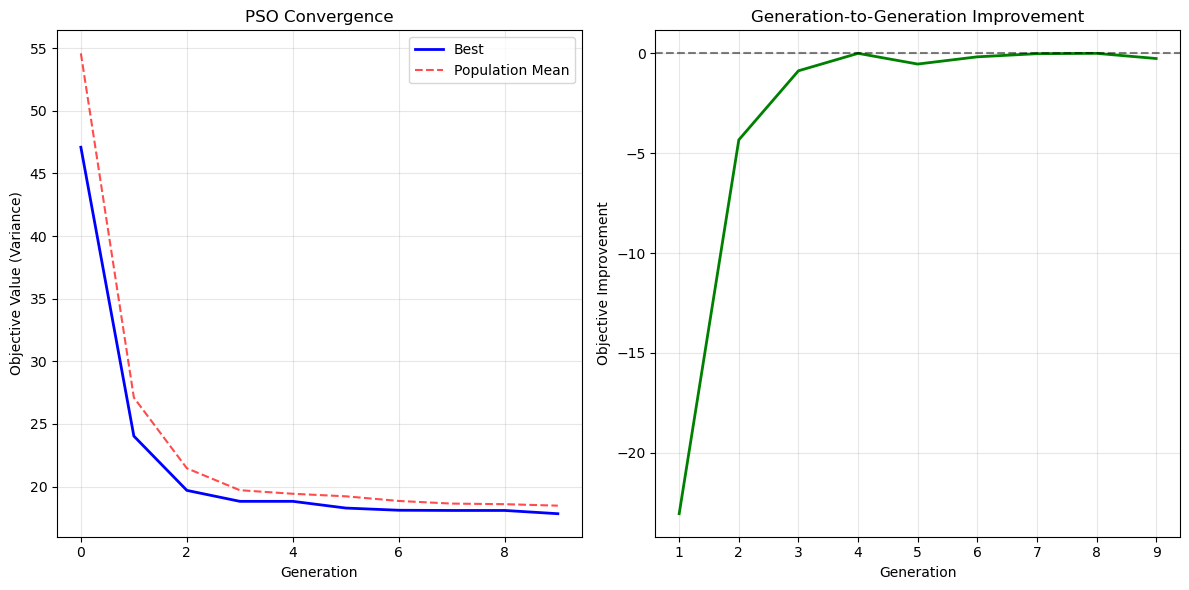


📈 CONVERGENCE STATISTICS:
   Initial objective: 47.088880
   Final objective: 17.840472
   Total improvement: -29.248408 (-62.11%)


In [24]:
# Plot convergence
history = result.optimization_history

if history:
    generations = [gen['generation'] for gen in history]
    best_objectives = [gen['best_objective'] for gen in history]
    mean_objectives = [gen['mean_objective'] for gen in history]
    
    plt.figure(figsize=(12, 6))
    
    # Plot convergence
    plt.subplot(1, 2, 1)
    plt.plot(generations, best_objectives, 'b-', label='Best', linewidth=2)
    plt.plot(generations, mean_objectives, 'r--', label='Population Mean', alpha=0.7)
    plt.xlabel('Generation')
    plt.ylabel('Objective Value (Variance)')
    plt.title('PSO Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot improvement rate
    plt.subplot(1, 2, 2)
    if len(best_objectives) > 1:
        improvements = [best_objectives[i] - best_objectives[i-1] for i in range(1, len(best_objectives))]
        plt.plot(generations[1:], improvements, 'g-', linewidth=2)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Generation')
    plt.ylabel('Objective Improvement')  
    plt.title('Generation-to-Generation Improvement')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Convergence statistics
    final_improvement = best_objectives[-1] - best_objectives[0]
    print(f"\n📈 CONVERGENCE STATISTICS:")
    print(f"   Initial objective: {best_objectives[0]:.6f}")
    print(f"   Final objective: {best_objectives[-1]:.6f}")
    print(f"   Total improvement: {final_improvement:.6f} ({(final_improvement/best_objectives[0]*100):+.2f}%)")
    
    # Find when major improvements stopped
    if len(improvements) > 10:
        recent_improvements = improvements[-10:]
        avg_recent_improvement = np.mean(recent_improvements)
        print(f"   Recent improvement rate: {avg_recent_improvement:.8f} per generation")
        if abs(avg_recent_improvement) < abs(final_improvement) * 0.01:
            print("   🏁 Algorithm appears to have converged (minimal recent progress)")
        else:
            print("   🔄 Algorithm still making progress when terminated")


### Solution Visualization  

Visualize the spatial changes in service coverage.

=== SPATIAL COVERAGE VISUALIZATION ===


TypeError: HexagonalZoneSystem.visualize_spatial_coverage() got an unexpected keyword argument 'ax'

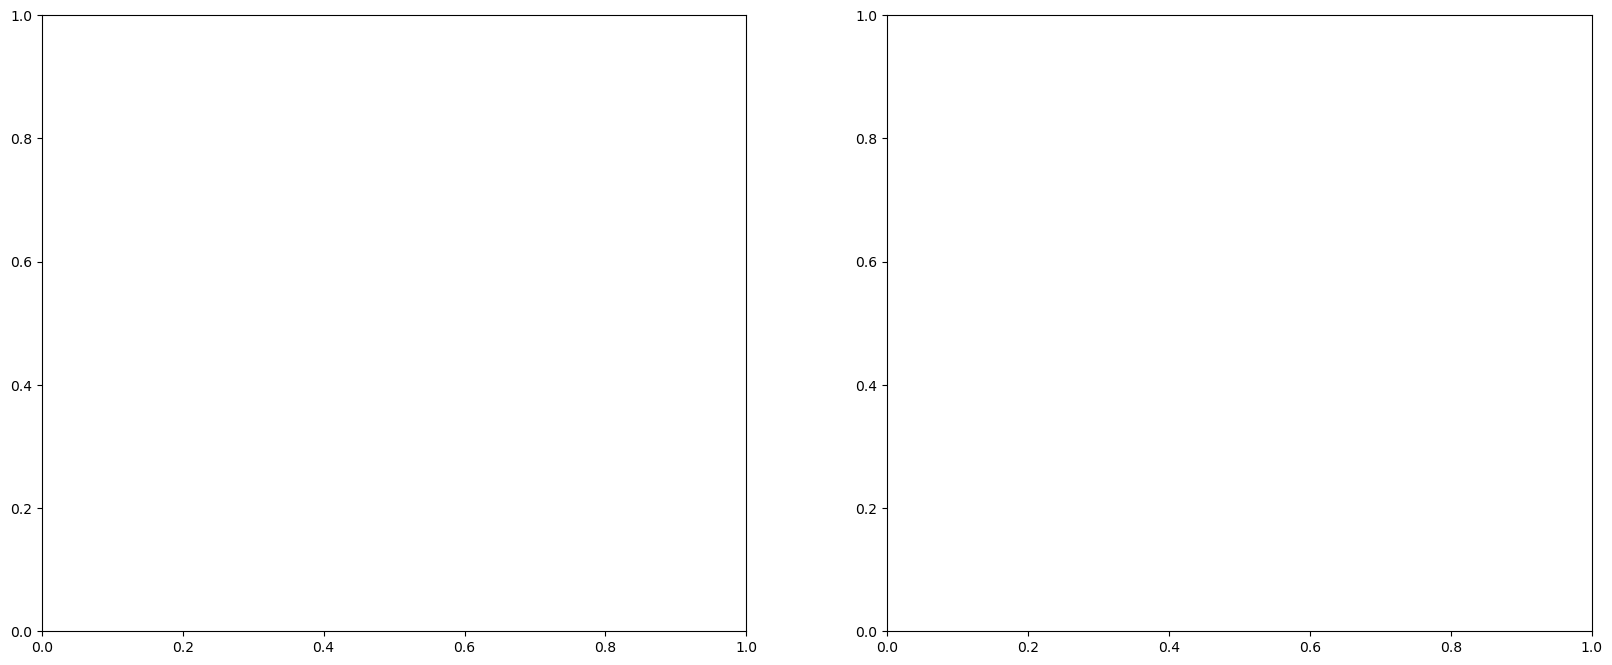

In [25]:

print("=== SPATIAL COVERAGE VISUALIZATION ===")

# Visualize current vs optimized coverage
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Current solution
coverage_objective.spatial_system.visualize_spatial_coverage(
    solution_matrix=opt_data['initial_solution'],
    optimization_data=opt_data,
    figsize=None,  # Use subplot
    ax=axes[0],
    show_stops=True
)
axes[0].set_title(f'Current Service Coverage\nVariance: {current_analysis["variance_average"]:.4f}', fontsize=14)

# Optimized solution  
coverage_objective.spatial_system.visualize_spatial_coverage(
    solution_matrix=result.best_solution,
    optimization_data=opt_data,
    figsize=None,  # Use subplot
    ax=axes[1], 
    show_stops=True
)
axes[1].set_title(f'Optimized Service Coverage\nVariance: {solution_analysis["variance_average"]:.4f}', fontsize=14)

plt.tight_layout()
plt.show()

variance_improvement = ((current_analysis['variance_average'] - solution_analysis['variance_average']) / current_analysis['variance_average']) * 100
print(f"🎯 Spatial equity improvement: {variance_improvement:+.1f}% reduction in coverage variance")

print("\n✅ Single optimization analysis complete!")